In [2]:
# Cell 1 – libraries
import numpy as np
from numpy import exp, log, sqrt
from scipy.stats import norm, qmc
from tqdm.auto import trange
import matplotlib.pyplot as plt


Simulating HHK paths: 100%|██████████| 30/30 [00:00<00:00, 1921.35it/s]


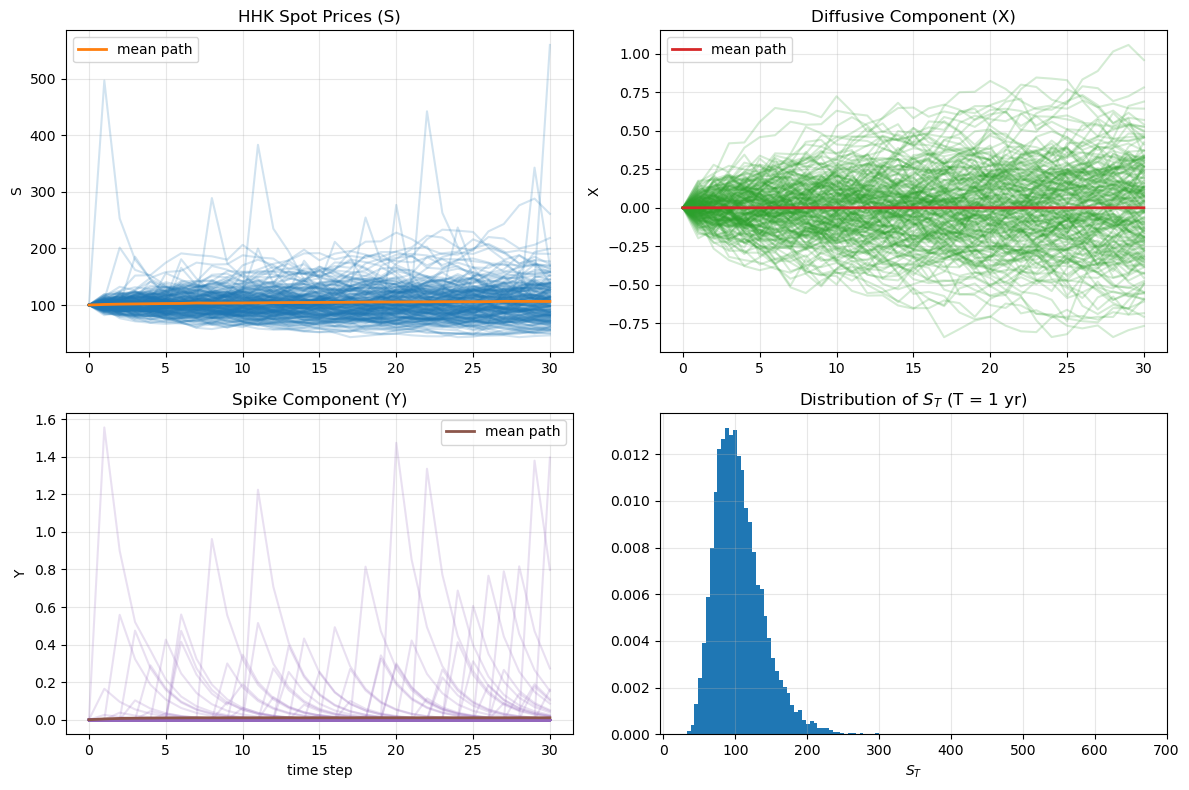

In [13]:
# Cell 2 – Sobol Monte-Carlo simulator for the HHK electricity-spot model
def HHKSim(
        S0: float,
        X0: float,
        Y0: float,
        alpha: float,
        beta: float,
        sigma: float,
        lam: float,
        mu_J: float,
        f_func,
        dt: float,
        T_steps: int,
        N_paths: int,
        assume_one_jump_per_dt: bool = True,
        _show_progress: bool = True,
        seed: int | None = None
    ):
    """
    Simulates the Hambly-Howison-Kluge spike-diffusion electricity model.

    Parameters
    ----------
    S0 : float
        Initial spot price.
    X0 : float
        Initial OU level.
    Y0 : float
        Initial spike level.
    alpha : float
        Mean-reversion rate of X (diffusive part).
    beta : float
        Mean-reversion rate of Y (spike part).
    sigma : float
        Diffusive volatility parameter.
    lam : float
        Poisson jump intensity λ.
    mu_J : float
        Mean jump size μ_J (J ~ Exp(1/μ_J)).
    f_func : callable
        Deterministic seasonality  f(t).
    dt : float
        Time increment.
    T_steps : int
        Number of time steps.
    N_paths : int
        Number of simulated paths (power of two recommended).
    assume_one_jump_per_dt : bool, optional
        If True (default) use Bernoulli λ dt for jump arrival.
        Works well for small dt; decrease dt if λ dt ≳ 0.1.
    _show_progress : bool, optional
        Display tqdm progress bar.
    seed : int | None, optional
        Seed for Sobol scrambling.

    Returns
    -------
    S : ndarray
        Spot price paths, shape (N_paths, T_steps+1).
    X : ndarray
        Diffusive component, shape (N_paths, T_steps+1).
    Y : ndarray
        Spike component, shape (N_paths, T_steps+1).
    """
    # --- pre-checks ---------------------------------------------------------
    assert np.log2(N_paths).is_integer(), "N_paths should be a power of two for Sobol quality."
    assert dt > 0 and T_steps > 0

    # --- pre-compute constants ---------------------------------------------
    E_alpha = exp(-alpha*dt)
    E_beta  = exp(-beta*dt)
    var_X   = sigma**2/(2*alpha)*(1 - exp(-2*alpha*dt))
    p_jump  = 1.0 - exp(-lam*dt)                 # jump probability per step

    # --- Sobol sequence -----------------------------------------------------
    # need three uniforms per step: Z (Brownian), U1 (jump yes/no), U2 (jump size)
    dim = 3*T_steps
    sampler = qmc.Sobol(d=dim, scramble=True, seed=seed)
    U_mat   = sampler.random(n=N_paths)          # shape (N_paths , dim)

    # unpack Sobol coordinates
    Z_norm = norm.ppf(U_mat[:, 0*T_steps:1*T_steps])   # Brownian increments
    U_evt  = U_mat[:, 1*T_steps:2*T_steps]             # jump occurrence
    U_jmp  = U_mat[:, 2*T_steps:3*T_steps]             # jump size uniforms

    # transpose for vectorised time loop: shape (T_steps, N_paths)
    Z_norm, U_evt, U_jmp = Z_norm.T, U_evt.T, U_jmp.T

    # --- containers ---------------------------------------------------------
    S = np.empty((T_steps+1, N_paths))
    X = np.empty_like(S)
    Y = np.empty_like(S)

    S[0] = S0
    X[0] = X0
    Y[0] = Y0

    # --- main simulation loop ----------------------------------------------
    for t in trange(1, T_steps+1, desc="Simulating HHK paths",
                    disable=not _show_progress):
        # OU diffusion -------------------------------------------------------
        X[t] = X[t-1]*E_alpha + sqrt(var_X)*Z_norm[t-1]

        # Spike process ------------------------------------------------------
        if assume_one_jump_per_dt:
            jumps   = (U_evt[t-1] < p_jump)                    # boolean mask
            J_size  = -mu_J * np.log(1.0 - U_jmp[t-1])         # exponential
            Y[t]    = Y[t-1]*E_beta + jumps*J_size
        else:
            # generic Poisson count using inverse-CDF on a Sobol uniform
            counts  = np.floor(-np.log(1.0-U_evt[t-1])/ (lam*dt)).astype(int)
            J_size  = -mu_J * np.log(1.0 - U_jmp[t-1])
            Y[t]    = Y[t-1]*E_beta + counts*J_size

        # Spot price ---------------------------------------------------------
        S[t] = exp(f_func(t*dt) + X[t] + Y[t])
        # S[t] = exp(X[t] + Y[t])

    # reshape to (N_paths, T_steps+1) ---------------------------------------
    S = S.T
    X = X.T
    Y = Y.T
    return S, X, Y

# Cell 3 – run a quick test with the paper’s baseline parameters
# Parameters from Hambly–Howison–Kluge, Fig. 1
f = lambda tau: np.log(100.0) + 0.5*np.cos(2*np.pi*tau)   # deterministic seasonality
f = lambda tau: np.log(100.0)
params = dict(
    S0=100.0, X0=0.0, Y0=0.0,    # initial values
    alpha=7.0, beta=200.0,
    sigma=1.4,
    lam=4.0,
    mu_J=0.4,
    f_func=f,
    dt=1/365,                    # daily steps
    T_steps=30,                 # one-year horizon
    N_paths=2**14,               # 2**14=16384 paths
    seed=42
)

S, X, Y = HHKSim(**params)

# Plot S, X, Y in a 3x1 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot S (spot prices)
axes[0, 0].grid(True, alpha=0.3, zorder=0)
axes[0, 0].plot(S[:200, :].T, alpha=0.2, color='tab:blue')
axes[0, 0].plot(S.mean(axis=0), color='tab:orange', linewidth=2, label="mean path")
axes[0, 0].set_title("HHK Spot Prices (S)")
axes[0, 0].set_ylabel("S")
axes[0, 0].legend()

# Plot X (diffusive component)
axes[0, 1].grid(True, alpha=0.3, zorder=0)
axes[0, 1].plot(X[:200, :].T, alpha=0.2, color='tab:green')
axes[0, 1].plot(X.mean(axis=0), color='tab:red', linewidth=2, label="mean path")
axes[0, 1].set_title("Diffusive Component (X)")
axes[0, 1].set_ylabel("X")
axes[0, 1].legend()

# Plot Y (spike component)
axes[1, 0].grid(True, alpha=0.3, zorder=0)
axes[1, 0].plot(Y[:200, :].T, alpha=0.2, color='tab:purple')
axes[1, 0].plot(Y.mean(axis=0), color='tab:brown', linewidth=2, label="mean path")
axes[1, 0].set_title("Spike Component (Y)")
axes[1, 0].set_xlabel("time step")
axes[1, 0].set_ylabel("Y")
axes[1, 0].legend()

axes[1, 1].grid(True, alpha=0.3, zorder=0)
axes[1, 1].hist(S[:, -1], bins=120, density=True)
axes[1, 1].set_title("Distribution of $S_T$ (T = 1 yr)")
axes[1, 1].set_xlabel("$S_T$")

plt.tight_layout()
plt.show()


---

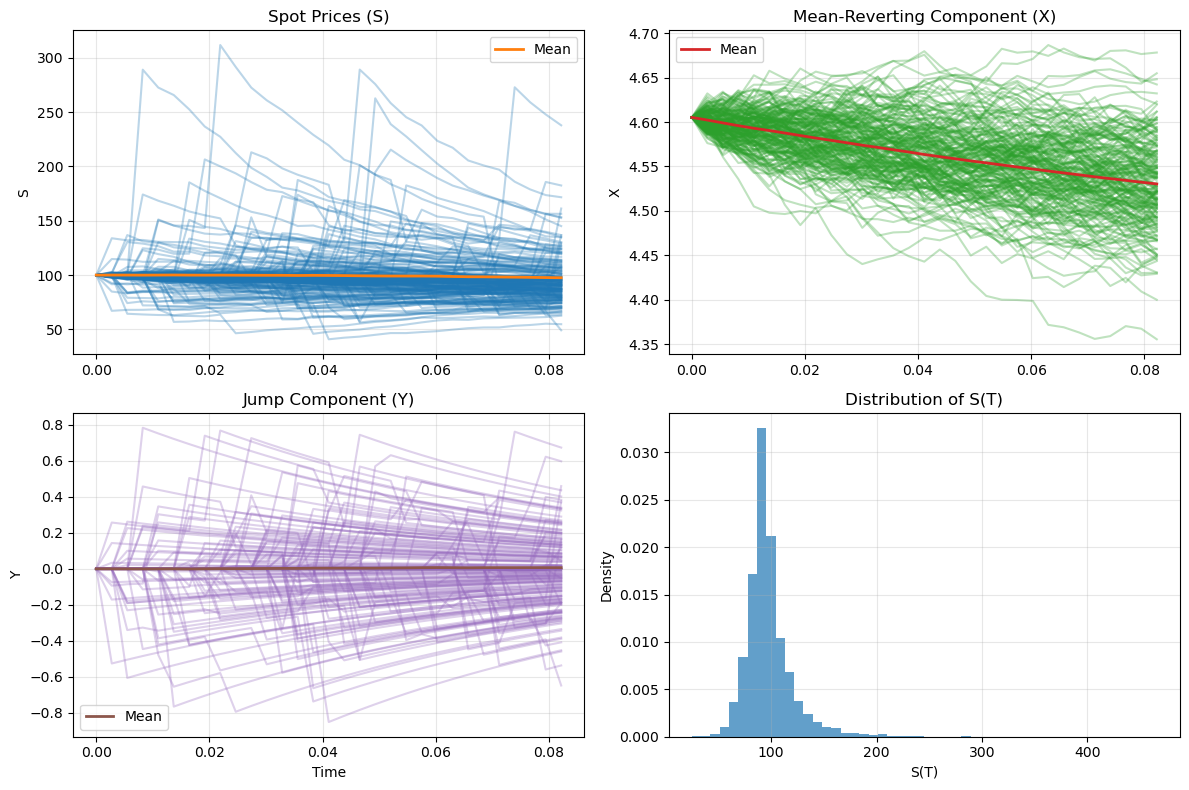

Final spot price statistics:
Mean: 97.58
Std: 23.19
Min: 24.61
Max: 466.07


In [29]:
import numpy as np

def simulate_kluge_spot(
    S0: float,
    T: float,
    n_steps: int,
    n_paths: int,
    kappa_m: float, sigma_m: float, theta_m: float,
    kappa_y: float, sigma_y: float,
    lambda_J: float, mu_J: float, sigma_J: float,
    rho: float = 0.0,
    antithetic: bool = False,
    seed: int | None = None,
):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    t_grid = np.linspace(0.0, T, n_steps + 1)

    # exact-form OU coefficients
    em_m  = np.exp(-kappa_m * dt)
    var_m = sigma_m**2 * (1.0 - em_m**2) / (2.0 * kappa_m)
    em_y  = np.exp(-kappa_y * dt)
    var_y = sigma_y**2 * (1.0 - em_y**2) / (2.0 * kappa_y)

    # Cholesky for correlated Gaussians
    L = np.array([[1.0, 0.0],
                  [rho, np.sqrt(1.0 - rho**2)]])

    n_sim = n_paths * (2 if antithetic else 1)
    
    # Pre-generate all random variables
    # Gaussian random variables for both processes (shape: n_steps, 2, n_sim)
    z_all = rng.standard_normal((n_steps, 2, n_sim))
    z_all = np.einsum('ij,kjl->kil', L, z_all)  # Apply correlation
    
    # Poisson random variables for jump counts (shape: n_steps, n_sim)
    n_jumps_all = rng.poisson(lambda_J * dt, (n_steps, n_sim))
    
    # Normal random variables for jump sizes (shape: n_steps, n_sim)
    jump_sizes_all = rng.normal(
        mu_J * n_jumps_all,
        sigma_J * np.sqrt(np.maximum(n_jumps_all, 1))  # avoid sqrt(0)
    )
    # Set jump sizes to 0 where no jumps occur
    jump_sizes_all = np.where(n_jumps_all > 0, jump_sizes_all, 0.0)
    
    # Initialize state arrays
    X = np.empty((n_sim, n_steps + 1))
    Y = np.empty((n_sim, n_steps + 1))
    S = np.empty((n_sim, n_steps + 1))
    
    # Initial conditions
    X[:, 0] = np.log(S0)
    Y[:, 0] = 0.0
    S[:, 0] = S0

    # Simulation loop using pre-generated random variables
    for k in range(1, n_steps + 1):
        # Update X (mean-reverting process)
        X[:, k] = theta_m + (X[:, k-1] - theta_m) * em_m + np.sqrt(var_m) * z_all[k-1, 0, :]
        
        # Update Y (OU process with jumps)
        Y[:, k] = Y[:, k-1] * em_y + np.sqrt(var_y) * z_all[k-1, 1, :] + jump_sizes_all[k-1, :]
        
        # Update S (spot price)
        S[:, k] = np.exp(X[:, k] + Y[:, k])

    # Apply antithetic variates if requested
    if antithetic:
        half = n_paths
        S = 0.5 * (S[:half] + S[half:])
        X = 0.5 * (X[:half] + X[half:])
        Y = 0.5 * (Y[:half] + Y[half:])

    return t_grid, S[:n_paths], X[:n_paths], Y[:n_paths]

# Run simulation
t, spot_paths, X_paths, Y_paths = simulate_kluge_spot(
    S0=100.0, T=30/365, n_steps=30, n_paths=10_000,
    kappa_m=5.0, sigma_m=0.3, theta_m=np.log(80),
    kappa_y=15.0, sigma_y=0.0,
    lambda_J=10.0, mu_J=0.0, sigma_J=0.5,
    rho=0.0, antithetic=True, seed=42
)

# Create 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

n_paths_to_plot = 200  # Number of paths to plot for clarity
# Plot S (spot prices) - top left
axes[0, 0].plot(t, spot_paths[:n_paths_to_plot].T, color='tab:blue', alpha=0.3)
axes[0, 0].plot(t, spot_paths.mean(axis=0), color='tab:orange', linewidth=2, label='Mean')
axes[0, 0].set_title('Spot Prices (S)')
axes[0, 0].set_ylabel('S')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot X (mean-reverting component) - top right
axes[0, 1].plot(t, X_paths[:n_paths_to_plot].T, color='tab:green', alpha=0.3)
axes[0, 1].plot(t, X_paths.mean(axis=0), color='tab:red', linewidth=2, label='Mean')
axes[0, 1].set_title('Mean-Reverting Component (X)')
axes[0, 1].set_ylabel('X')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot Y (jump component) - bottom left
axes[1, 0].plot(t, Y_paths[:n_paths_to_plot].T, color='tab:purple', alpha=0.3)
axes[1, 0].plot(t, Y_paths.mean(axis=0), color='tab:brown', linewidth=2, label='Mean')
axes[1, 0].set_title('Jump Component (Y)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Y')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Histogram of final spot prices - bottom right
axes[1, 1].hist(spot_paths[:, -1], bins=50, density=True, alpha=0.7, color='tab:blue')
axes[1, 1].set_title('Distribution of S(T)')
axes[1, 1].set_xlabel('S(T)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Final spot price statistics:")
print(f"Mean: {spot_paths[:, -1].mean():.2f}")
print(f"Std: {spot_paths[:, -1].std():.2f}")
print(f"Min: {spot_paths[:, -1].min():.2f}")
print(f"Max: {spot_paths[:, -1].max():.2f}")

---

Simulated 16384 paths; mean S(T) = 97.10
ATM Call price ≈ 8.6006  (SE 0.2015)


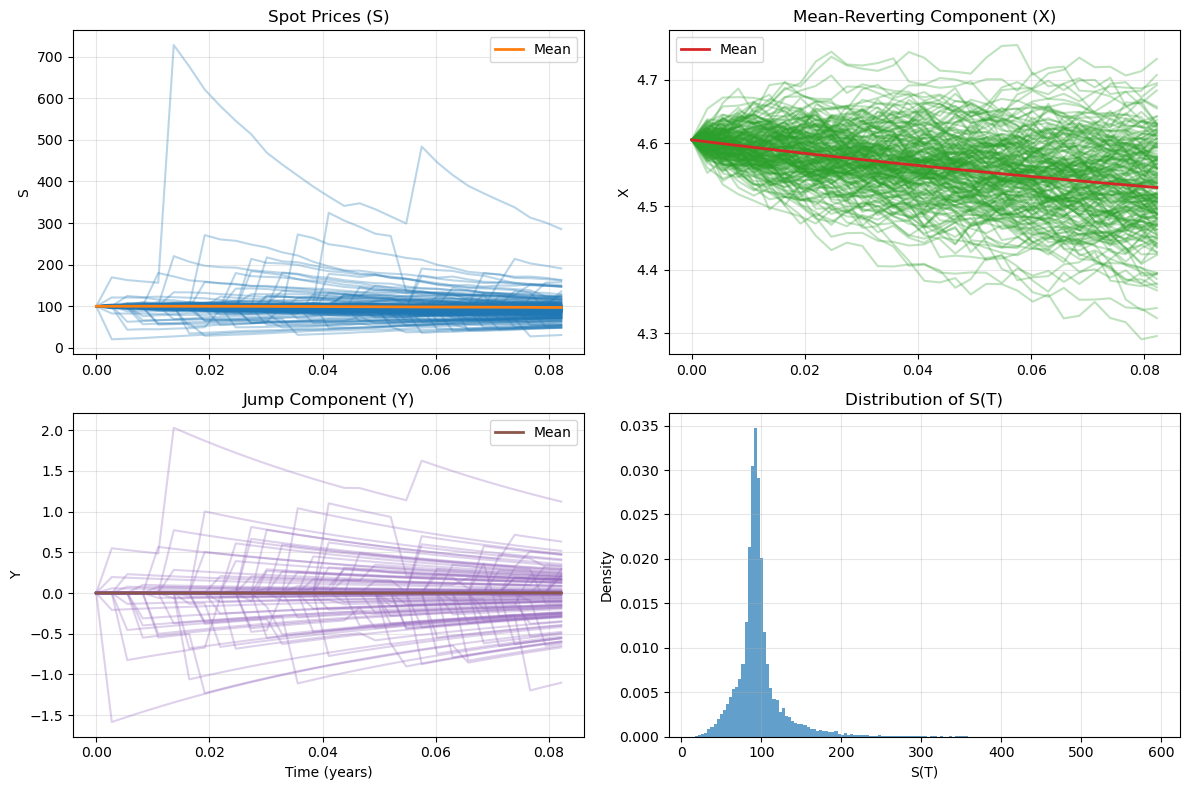


Final spot price statistics:
Mean: 97.10
Std : 32.59
Min : 13.12


In [38]:
import numpy as np
from scipy.stats import qmc, norm, poisson
import matplotlib.pyplot as plt

def simulate_kluge_spot(
    S0: float,
    T: float,
    n_steps: int,
    n_paths: int,
    kappa_m: float,
    sigma_m: float,
    theta_m: float,
    kappa_y: float,
    sigma_y: float,
    lambda_J: float,
    mu_J: float,
    sigma_J: float,
    rho: float = 0.0,
    seed: int | None = None,
):
    """Return time grid *t*, spot paths *S*, and state paths *X*, *Y*.

    All random numbers are drawn from an Owen‑scrambled Sobol sequence so the
    estimator retains unbiasedness but gains the low‑discrepancy convergence
    rate.
    """

    dt = T / n_steps
    t_grid = np.linspace(0.0, T, n_steps + 1)

    # Exact OU coefficients
    em_m = np.exp(-kappa_m * dt)
    var_m = sigma_m**2 * (1.0 - em_m**2) / (2.0 * kappa_m)
    em_y = np.exp(-kappa_y * dt)
    var_y = sigma_y**2 * (1.0 - em_y**2) / (2.0 * kappa_y)

    # Cholesky for correlated Gaussians (Z_m, Z_y)
    L = np.array([[1.0, 0.0], [rho, np.sqrt(1.0 - rho**2)]])

    # ------------- Sobol backbone ------------------------------------------------
    dims_per_step = 4  # Z_m, Z_y, U_Poisson, Z_jump_size
    dim = dims_per_step * n_steps

    sampler = qmc.Sobol(d=dim, scramble=True, seed=seed)
    u = sampler.random(n_paths)  # (n_paths, dim)
    u = u.reshape(n_paths, n_steps, dims_per_step).transpose(1, 0, 2)  # (n_steps, n_paths, 4)

    eps = 1e-12  # avoid ±inf in ppf
    u = np.clip(u, eps, 1 - eps)

    z_m_raw = norm.ppf(u[:, :, 0])
    z_y_raw = norm.ppf(u[:, :, 1])
    n_jumps = poisson.ppf(u[:, :, 2], lambda_J * dt).astype(int)
    z_jump = norm.ppf(u[:, :, 3])

    # Correlate Gaussian factors
    z_stack = np.stack((z_m_raw, z_y_raw), axis=1)  # (n_steps, 2, n_paths)
    z_corr = np.einsum("ij,kjl->kil", L, z_stack)
    z_m = z_corr[:, 0]
    z_y = z_corr[:, 1]

    # Jump sizes
    jump_sizes = mu_J * n_jumps + sigma_J * np.sqrt(np.maximum(n_jumps, 1)) * z_jump
    jump_sizes = np.where(n_jumps > 0, jump_sizes, 0.0)

    # State arrays
    X = np.empty((n_paths, n_steps + 1))
    Y = np.empty((n_paths, n_steps + 1))
    S = np.empty((n_paths, n_steps + 1))
    X[:, 0] = np.log(S0)
    Y[:, 0] = 0.0
    S[:, 0] = S0

    for k in range(1, n_steps + 1):
        X[:, k] = theta_m + (X[:, k - 1] - theta_m) * em_m + np.sqrt(var_m) * z_m[k - 1]
        Y[:, k] = (
            Y[:, k - 1] * em_y + np.sqrt(var_y) * z_y[k - 1] + jump_sizes[k - 1]
        )
        S[:, k] = np.exp(X[:, k] + Y[:, k])

    return t_grid, S, X, Y

# %% Parameters – edit here
# %% Run simulation with parameters defined inline
_t, _S, _X, _Y = simulate_kluge_spot(
    S0=100.0,
    T=30 / 365,
    n_steps=30,
    n_paths=16_384,
    kappa_m=5.0,
    sigma_m=0.3,
    theta_m=np.log(80),
    kappa_y=15.0,
    sigma_y=0.0,
    lambda_J=10.0,
    mu_J=0.0,
    sigma_J=0.5,
    rho=0.0,
    seed=42
)
print(f"Simulated {_S.shape[0]} paths; mean S(T) = {_S[:, -1].mean():.2f}")

# %% Quick payoff example – ATM call
payoff = np.maximum(_S[:, -1] - 100, 0.0)
price_est = payoff.mean()
se = payoff.std(ddof=1) / np.sqrt(payoff.shape[0])
print(f"ATM Call price ≈ {price_est:.4f}  (SE {se:.4f})")

# %% Diagnostic 2×2 plot and summary stats
n_paths_to_plot = 200  # tweak for readability
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Top‑left: spot paths
axes[0, 0].plot(_t, _S[:n_paths_to_plot].T, color="tab:blue", alpha=0.3)
axes[0, 0].plot(_t, _S.mean(axis=0), color="tab:orange", lw=2, label="Mean")
axes[0, 0].set_title("Spot Prices (S)")
axes[0, 0].set_ylabel("S")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# Top‑right: X factor
axes[0, 1].plot(_t, _X[:n_paths_to_plot].T, color="tab:green", alpha=0.3)
axes[0, 1].plot(_t, _X.mean(axis=0), color="tab:red", lw=2, label="Mean")
axes[0, 1].set_title("Mean‑Reverting Component (X)")
axes[0, 1].set_ylabel("X")
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# Bottom‑left: Y factor
axes[1, 0].plot(_t, _Y[:n_paths_to_plot].T, color="tab:purple", alpha=0.3)
axes[1, 0].plot(_t, _Y.mean(axis=0), color="tab:brown", lw=2, label="Mean")
axes[1, 0].set_title("Jump Component (Y)")
axes[1, 0].set_xlabel("Time (years)")
axes[1, 0].set_ylabel("Y")
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# Bottom‑right: histogram of terminal prices
axes[1, 1].hist(_S[:, -1], bins=150, density=True, alpha=0.7, color="tab:blue")
axes[1, 1].set_title("Distribution of S(T)")
axes[1, 1].set_xlabel("S(T)")
axes[1, 1].set_ylabel("Density")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal spot price statistics:")
print(f"Mean: {_S[:, -1].mean():.2f}")
print(f"Std : {_S[:, -1].std():.2f}")
print(f"Min : {_S[:, -1].min():.2f}")
